In [1]:
import os
import sys
sys.path.append(os.path.expanduser("~"))
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D
from utils import draw_figure,compute_pk, plot_residual, test_plot
import comet_ml
import torch
from torch import nn
from torch.nn.functional import mse_loss, l1_loss
from torch import autograd, Tensor
from lightning.pytorch import LightningModule, Trainer, seed_everything
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from typing import Optional, Tuple
from torch.special import expm1
from tqdm import trange
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('highest')
device = torch.device("cuda") if torch.cuda.is_available() else "mps"
print(device)

cuda


In [2]:
seed_everything(7, workers=True)
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'
learning_rate = 1e-3 #1e-4


[rank: 0] Seed set to 7


In [39]:
class trainCNN(LightningModule):
    def __init__(
        self,
        model,
        learning_rate: float = 3.0e-5,
        weight_decay: float = 1.0e-2,
        n_sampling_steps: int = 250, #1000
        fourier_upweight_range=(3, 10), 
        fourier_weight=1e-5,
        draw_figure=None,
        test_plot=None,
        dataset='illustris',
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["draw_figure","plot_residual"])
        
        self.model= model
        self.dataset=dataset
        print("suite:", self.dataset)
        self.draw_figure=draw_figure
        self.test_plot=test_plot
        self.fourier_upweight_range = fourier_upweight_range
        self.fourier_weight = fourier_weight
        self.n_sampling_steps = n_sampling_steps
        
        if self.draw_figure is None:
            def draw_figure(args,**kwargs):
                fig=plt.figure(figsize=(5,5))
                return fig
            self.draw_figure=draw_figure

    def forward(self, cdm_map, params) -> Tensor:
        cdm_map = cdm_map
        params = params
        output = self.model(cdm_map, params, inverse_blue_filter=False, high_pass=False) #output kernel should give the invertible Fourier transformation
        #if not self.training:
            #output = self.model(cdm_map, params, inverse_blue_filter=True, high_pass=False, order=3)
        return output

    def evaluate(self, batch: Tuple, stage: str = None) -> Tensor:

        cdm_map,params,true_map = batch
        cdm_map = cdm_map.to(device)
        params = params.to(device)
        true_map = true_map.to(device)
        mtot_pred = self(cdm_map,params).to(device)
        fourier_loss = self.fourier_loss(mtot_pred, true_map)
        # Log the individual loss components
        self.log("fourier_loss", fourier_loss, on_epoch=True, prog_bar=True)
        loss = l1_loss(mtot_pred, true_map)
        self.log("weighted_l1_loss", loss, on_epoch=True, prog_bar=True)
        return fourier_loss
        

    def get_current_max_freq(self):
        """Calculate current maximum frequency based on training progress"""
        if self.trainer is None:
            return self.fourier_upweight_range[1]
            
        progress = self.current_epoch / self.trainer.max_epochs
        max_freq = self.fourier_upweight_range[1]
    
        if progress < 0.33:
            return max_freq / 3
        elif progress < 0.66:
            return (max_freq * 2) / 3
        else:
            return max_freq

    def get_current_min_freq(self):
        """Calculate current maximum frequency based on training progress"""
        if self.trainer is None:
            return self.fourier_upweight_range[0]
            
        progress = self.current_epoch / self.trainer.max_epochs
        min_freq = self.fourier_upweight_range[0]
    
        if progress < 0.33:
            return 0.5
        elif progress < 0.66:
            return (min_freq * 2) / 3
        else:
            return min_freq
       
    
    def fourier_loss(self, output, target):

        output_fft = torch.fft.fft2(output)
        target_fft = torch.fft.fft2(target)
    
        _, C, H, W = output.shape
        # channel:{C} = 1
        L = 25. #Mpc/c

        kx = torch.fft.fftfreq(H, d=1. / (H * 2 * np.pi / L)).to(output.device)
        ky = torch.fft.fftfreq(W, d=1. / (W * 2 * np.pi / L)).to(output.device)
        kx, ky = torch.meshgrid(kx, ky, indexing="ij") #[256, 256],[256, 256]
        k = torch.sqrt(kx**2 + ky**2) 


        ## Blue weighted filter FFT−1 (FFT(img)*k^order)
        #order = 3
        #weight_mask = k**order
        #weight_mask[0, 0] = 1.0 
        
        ## Low pass only
        high =self.get_current_max_freq() # self.fourier_upweight_range[1] #
        low = self.fourier_upweight_range[0] #self.get_current_min_freq() #
        order = 2 #2
        low_pass = 1 / (1 + (k / high)**(2 * order))
        high_pass = 1 / (1 + (low / k)**(2 * order))
        weight_mask = self.fourier_weight*(low_pass+1)

        ## Window Functions
        #weight_mask = self.fourier_weight*low_pass*high_pass #change to Butterworth filter
        
        
        #weight_mask = torch.zeros_like(k)
        #weight_mask[(k >= low) & (k <= high)] = self.fourier_weight # Double weight in the range
    
        # Expand the mask for all batches and channels
        weight_mask = weight_mask[None, None, :, :].to(output.device)
    
        loss = torch.mean( (weight_mask * output_fft - weight_mask * target_fft).real ** 2) + torch.mean((weight_mask * output_fft - weight_mask * target_fft).imag ** 2) #r_cc is phase not mag

        return loss

    def rcc_mean(self,batch):
        cdm_map,params,true_map = batch
        cdm_map = cdm_map.to(device)
        params = params.to(device)
        target_mtot = true_map.to(device) + cdm_map
        pred_mtot = self(cdm_map,params).to(device) + cdm_map
        kcc, P = compute_pk(target_mtot.cpu().numpy(), pred_mtot.cpu().numpy())

        return P.mean()
        

    def training_step(
        self,
        batch: Tuple,
        batch_idx: int,
    ) -> Tensor:
        loss = self.evaluate(batch, "train")
        self.log("train_loss", loss, on_epoch=True)
        log_loss = torch.log(loss)
        return log_loss


    def validation_step(self, batch: Tuple, batch_idx: int) -> Tensor:
        """validate model

        Args:
            batch (Tuple): batch of examples
            batch_idx (int): idx for batch

        Returns:
            Tensor: loss
        """
        conditioning,params,x = batch 
        loss = 0   
        
        if batch_idx == 0:
            sample = self(conditioning,params)
            loss = self.evaluate(batch)
            self.log("val_loss", loss, on_epoch=True, prog_bar=True)
            rcc = self.rcc_mean(batch)
            self.log("val_rcc", rcc, on_epoch=True, prog_bar=True)
            
            fig = self.draw_figure(x,sample,conditioning,self.dataset,model='UNet')            
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
          
            plt.close()
        return loss

    def test_step(self, batch, batch_idx):
        
        conditioning, params, x = batch    
        loss = 0    
        
        if batch_idx == 0:
            sample = self(conditioning,params)
            fig = self.draw_figure(x,sample,conditioning,self.dataset,model='UNet')
            fig_test = self.test_plot(x,sample,conditioning,self.dataset,model='UNet')
            self.log_dict({'test_loss': loss}, on_epoch=True)
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                self.logger.experiment.log_figure(figure=fig_test)

                loss = self.evaluate(batch, "test")
                self.logger.log_metrics({"test_loss": loss.mean()})
            plt.show()
        return self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )
        
        warmup_steps = int(self.trainer.max_steps * 0.1)

        scheduler = torch.optim.lr_scheduler.SequentialLR(
            optimizer,
            schedulers=[
                # Linear warmup
                torch.optim.lr_scheduler.LinearLR(
                    optimizer, 
                    start_factor=0.1, 
                    end_factor=1.0, 
                    total_iters=warmup_steps
                ),
                # Cosine Annealing with Warm Restarts
                torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                    optimizer, 
                    T_0=10,           # Initial restart period
                    T_mult=2,     # Multiplicative factor for restart periods
                    eta_min=1e-6    # Minimum learning rate
                )
            ],
            milestones=[warmup_steps]
        )
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        cdm_map,params,true_map = batch
        return self(cdm_map,params)

In [4]:
import importlib
import unet_parts
import unet_model
import camel_dataloader
import utils

importlib.reload(camel_dataloader) 
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D

importlib.reload(utils) 
importlib.reload(unet_parts) 
from utils import draw_figure,test_plot

importlib.reload(unet_model) 
from unet_model import UNetFiLM,UNetFiLMNoSkip

In [40]:
sys.path.append('/pscratch/sd/l/lindajin/Pytorch-UNet/unet')
from unet_model import UNetFiLM,ResNetFiLM,UNetFiLMNoSkip
cnn = trainCNN(
        model =UNetFiLM(1,1, bilinear = False, use_fourier_features = True), #.to(device) #SimpleNet() #ResnetGenerator(1,1) #SimpleNet()
        dataset=dataset,
        image_shape=(1,cropsize,cropsize),
        draw_figure=draw_figure,
        test_plot=test_plot
    ).to(device)

    # Checkpoint every time val_loss improves
val_checkpoint = ModelCheckpoint(
        filename="best_model-{epoch}-{step}",
        monitor="val_rcc",
        save_top_k=1, # save only the best ckpt
        mode="max",
        verbose=True,        
    )

    # Checkpoint at every 6000 steps
latest_checkpoint = ModelCheckpoint(
        filename="latest-{epoch}-{step}",
        monitor="step",
        mode="max",
        every_n_train_steps=50, # 50 6000
        save_top_k=10
    )

comet_logger = CometLogger(
            api_key=os.environ.get("COMET_API_KEY"),
            project_name="Nbody_Hydro",
            experiment_name='UNet_Film_vali_rcc_lr_tuning_warmup_fourier_feature_6_7_epoch20_moving_highk_log_Fourier_ONLY_weight_1e5_10_Smooth_Butterworth_lr_3e5_adamw_1e2_25_thickness_Nbody',
            offline=False,
            save_dir='/pscratch/sd/l/lindajin/LOGS/'
        )

trainer = Trainer(
        logger=comet_logger,
        accelerator="auto",
        max_epochs=20, #10 1000
        gradient_clip_val=0.5,
        callbacks=[LearningRateMonitor(),
                    latest_checkpoint,
                    val_checkpoint]
    )

CometLogger will be initialized in online mode
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


no skip connection on last layer
suite: Astrid


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [18]:
print(cnn.device)

cuda:0


In [15]:
import importlib
import unet_model
import unet_parts
import utils
importlib.reload(utils) 
importlib.reload(unet_parts) 
from utils import power, draw_figure
from unet_model import UNetFiLM, FiLM, ResNetFiLM
from unet_parts import *

## Conditional ResNet: m_cdm -> m_tot (25 thickness)

In [8]:
dm_25_thick_mtot = get_astro_data(
        dataset,
        25,
        num_workers=num_workers,
        batch_size=batch_size,
    )

In [23]:
trainer.fit(model=cnn, datamodule=dm_25_thick_mtot) 

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/f1270bef521a4ef9baed95e5a6fbefaa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | ResNetFiLM | 21.9 M | train
---------------------------------------------
21.9 M    Trainable params
0         Non-trainable params
21.9 M    Total params
87.748    Total estimated model params size (MB)
121       Modules in train mode
0         Modules in eval mode
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'ResNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64,

no high passing DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
no high pass

Computing power spectra of the fields...
Time FFTS = 0.79                                                   
Time loop = 0.00
Time taken = 0.81 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS 

/global/homes/l/lindajin/utils.py:97: RuntimeWarning: invalid value encountered in divide
  Pkcc = PKL.XPk_plane(x_, x2_,  BoxSize, MAS, MAS, threads=1)


no high passing DataLoader 0:  50%|█████     | 1/2 [00:07<00:07,  0.14it/s]
no high pass%|          | 0/175 [00:00<?, ?it/s]                           
no high pass%|          | 1/175 [00:00<00:26,  6.45it/s, v_num=efaa, fourier_loss_step=4.380, l1_loss_step=0.908]
no high pass%|          | 2/175 [00:00<00:22,  7.54it/s, v_num=efaa, fourier_loss_step=5.800, l1_loss_step=1.080]
no high pass%|▏         | 3/175 [00:00<00:21,  7.98it/s, v_num=efaa, fourier_loss_step=4.550, l1_loss_step=0.853]
no high pass%|▏         | 4/175 [00:00<00:20,  8.28it/s, v_num=efaa, fourier_loss_step=3.700, l1_loss_step=0.837]
no high pass%|▎         | 5/175 [00:00<00:20,  8.45it/s, v_num=efaa, fourier_loss_step=3.340, l1_loss_step=0.720]
no high pass%|▎         | 6/175 [00:00<00:19,  8.58it/s, v_num=efaa, fourier_loss_step=3.130, l1_loss_step=0.775]
no high pass%|▍         | 7/175 [00:00<00:19,  8.68it/s, v_num=efaa, fourier_loss_step=2.150, l1_loss_step=0.855]
no high pass%|▍         | 8/175 [00:00<00:19,  8.7

Epoch 0, global step 175: 'val_loss' reached 1.39301 (best 1.39301), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/best_model-epoch=0-step=175.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.610, l1_loss_step=0.548, fourier_loss=1.390, l1_loss=0.524, val_loss=1.390, fourier_loss_epoch=1.650, l1_loss_epoch=0.573]          
no high pass%|          | 1/175 [00:00<01:44,  1.67it/s, v_num=efaa, fourier_loss_step=1.870, l1_loss_step=0.521, fourier_loss=1.390, l1_loss=0.524, val_loss=1.390, fourier_loss_epoch=1.650, l1_loss_epoch=0.573]
no high pass%|          | 2/175 [00:00<01:01,  2.83it/s, v_num=efaa, fourier_loss_step=1.300, l1_loss_step=0.550, fourier_loss=1.390, l1_loss=0.524, val_loss=1.390, fourier_loss_epoch=1.650, l1_loss_epoch=0.573]
no high pass%|▏         | 3/175 [00:00<00:46,  3.69it/s, v_num=efaa, fourier_loss_step=1.560, l1_loss_step=0.516, fourier_loss=1.390, l1_loss=0.524, val_loss=1.390, fourier_loss_epoch=1.650, l1_loss_epoch=0.573]
no high pass%|▏         | 4/175 [00:00<00:39,  4.34it/s, v_num=efaa, fourier_loss_step=1.210, l1_loss_step=0.562, fourier_loss=1.390, l1_loss=0.524, v

Epoch 1, global step 350: 'val_loss' was not in top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.460, l1_loss_step=0.520, fourier_loss=1.400, l1_loss=0.544, val_loss=1.400, fourier_loss_epoch=1.420, l1_loss_epoch=0.541]          
no high pass%|          | 1/175 [00:00<01:13,  2.38it/s, v_num=efaa, fourier_loss_step=1.100, l1_loss_step=0.527, fourier_loss=1.400, l1_loss=0.544, val_loss=1.400, fourier_loss_epoch=1.420, l1_loss_epoch=0.541]
no high pass%|          | 2/175 [00:00<00:45,  3.79it/s, v_num=efaa, fourier_loss_step=1.300, l1_loss_step=0.504, fourier_loss=1.400, l1_loss=0.544, val_loss=1.400, fourier_loss_epoch=1.420, l1_loss_epoch=0.541]
no high pass%|▏         | 3/175 [00:00<00:36,  4.71it/s, v_num=efaa, fourier_loss_step=1.180, l1_loss_step=0.517, fourier_loss=1.400, l1_loss=0.544, val_loss=1.400, fourier_loss_epoch=1.420, l1_loss_epoch=0.541]
no high pass%|▏         | 4/175 [00:00<00:31,  5.37it/s, v_num=efaa, fourier_loss_step=1.300, l1_loss_step=0.543, fourier_loss=1.400, l1_loss=0.544, v

Epoch 2, global step 525: 'val_loss' reached 1.31727 (best 1.31727), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/best_model-epoch=2-step=525.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.150, l1_loss_step=0.608, fourier_loss=1.320, l1_loss=0.516, val_loss=1.320, fourier_loss_epoch=1.400, l1_loss_epoch=0.541]          
no high pass%|          | 1/175 [00:00<02:07,  1.37it/s, v_num=efaa, fourier_loss_step=1.080, l1_loss_step=0.542, fourier_loss=1.320, l1_loss=0.516, val_loss=1.320, fourier_loss_epoch=1.400, l1_loss_epoch=0.541]
no high pass%|          | 2/175 [00:00<01:12,  2.37it/s, v_num=efaa, fourier_loss_step=1.230, l1_loss_step=0.538, fourier_loss=1.320, l1_loss=0.516, val_loss=1.320, fourier_loss_epoch=1.400, l1_loss_epoch=0.541]
no high pass%|▏         | 3/175 [00:00<00:54,  3.16it/s, v_num=efaa, fourier_loss_step=1.460, l1_loss_step=0.563, fourier_loss=1.320, l1_loss=0.516, val_loss=1.320, fourier_loss_epoch=1.400, l1_loss_epoch=0.541]
no high pass%|▏         | 4/175 [00:01<00:45,  3.78it/s, v_num=efaa, fourier_loss_step=1.230, l1_loss_step=0.504, fourier_loss=1.320, l1_loss=0.516, v

Epoch 3, global step 700: 'val_loss' reached 1.30940 (best 1.30940), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/best_model-epoch=3-step=700.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.300, l1_loss_step=0.558, fourier_loss=1.310, l1_loss=0.536, val_loss=1.310, fourier_loss_epoch=1.390, l1_loss_epoch=0.540]          
no high pass%|          | 1/175 [00:00<01:16,  2.27it/s, v_num=efaa, fourier_loss_step=1.310, l1_loss_step=0.559, fourier_loss=1.310, l1_loss=0.536, val_loss=1.310, fourier_loss_epoch=1.390, l1_loss_epoch=0.540]
no high pass%|          | 2/175 [00:00<00:47,  3.65it/s, v_num=efaa, fourier_loss_step=1.110, l1_loss_step=0.585, fourier_loss=1.310, l1_loss=0.536, val_loss=1.310, fourier_loss_epoch=1.390, l1_loss_epoch=0.540]
no high pass%|▏         | 3/175 [00:00<00:37,  4.57it/s, v_num=efaa, fourier_loss_step=1.290, l1_loss_step=0.555, fourier_loss=1.310, l1_loss=0.536, val_loss=1.310, fourier_loss_epoch=1.390, l1_loss_epoch=0.540]
no high pass%|▏         | 4/175 [00:00<00:32,  5.23it/s, v_num=efaa, fourier_loss_step=1.040, l1_loss_step=0.547, fourier_loss=1.310, l1_loss=0.536, v

Epoch 4, global step 875: 'val_loss' was not in top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.350, l1_loss_step=0.501, fourier_loss=1.410, l1_loss=0.527, val_loss=1.410, fourier_loss_epoch=1.350, l1_loss_epoch=0.535]          
no high pass%|          | 1/175 [00:00<01:28,  1.96it/s, v_num=efaa, fourier_loss_step=1.620, l1_loss_step=0.541, fourier_loss=1.410, l1_loss=0.527, val_loss=1.410, fourier_loss_epoch=1.350, l1_loss_epoch=0.535]
no high pass%|          | 2/175 [00:00<00:53,  3.23it/s, v_num=efaa, fourier_loss_step=2.000, l1_loss_step=0.552, fourier_loss=1.410, l1_loss=0.527, val_loss=1.410, fourier_loss_epoch=1.350, l1_loss_epoch=0.535]
no high pass%|▏         | 3/175 [00:00<00:41,  4.11it/s, v_num=efaa, fourier_loss_step=0.970, l1_loss_step=0.502, fourier_loss=1.410, l1_loss=0.527, val_loss=1.410, fourier_loss_epoch=1.350, l1_loss_epoch=0.535]
no high pass%|▏         | 4/175 [00:00<00:35,  4.77it/s, v_num=efaa, fourier_loss_step=1.140, l1_loss_step=0.513, fourier_loss=1.410, l1_loss=0.527, v

Epoch 5, global step 1050: 'val_loss' reached 1.29843 (best 1.29843), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/best_model-epoch=5-step=1050.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.150, l1_loss_step=0.502, fourier_loss=1.300, l1_loss=0.518, val_loss=1.300, fourier_loss_epoch=1.340, l1_loss_epoch=0.532]          
no high pass%|          | 1/175 [00:00<01:17,  2.25it/s, v_num=efaa, fourier_loss_step=1.200, l1_loss_step=0.495, fourier_loss=1.300, l1_loss=0.518, val_loss=1.300, fourier_loss_epoch=1.340, l1_loss_epoch=0.532]
no high pass%|          | 2/175 [00:00<00:48,  3.58it/s, v_num=efaa, fourier_loss_step=1.720, l1_loss_step=0.512, fourier_loss=1.300, l1_loss=0.518, val_loss=1.300, fourier_loss_epoch=1.340, l1_loss_epoch=0.532]
no high pass%|▏         | 3/175 [00:00<00:38,  4.50it/s, v_num=efaa, fourier_loss_step=1.300, l1_loss_step=0.567, fourier_loss=1.300, l1_loss=0.518, val_loss=1.300, fourier_loss_epoch=1.340, l1_loss_epoch=0.532]
no high pass%|▏         | 4/175 [00:00<00:33,  5.16it/s, v_num=efaa, fourier_loss_step=1.180, l1_loss_step=0.553, fourier_loss=1.300, l1_loss=0.518, v

Epoch 6, global step 1225: 'val_loss' reached 1.26965 (best 1.26965), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/best_model-epoch=6-step=1225.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.110, l1_loss_step=0.523, fourier_loss=1.270, l1_loss=0.534, val_loss=1.270, fourier_loss_epoch=1.330, l1_loss_epoch=0.528]          
no high pass%|          | 1/175 [00:00<01:13,  2.37it/s, v_num=efaa, fourier_loss_step=1.520, l1_loss_step=0.529, fourier_loss=1.270, l1_loss=0.534, val_loss=1.270, fourier_loss_epoch=1.330, l1_loss_epoch=0.528]
no high pass%|          | 2/175 [00:00<00:46,  3.71it/s, v_num=efaa, fourier_loss_step=1.510, l1_loss_step=0.527, fourier_loss=1.270, l1_loss=0.534, val_loss=1.270, fourier_loss_epoch=1.330, l1_loss_epoch=0.528]
no high pass%|▏         | 3/175 [00:00<00:37,  4.64it/s, v_num=efaa, fourier_loss_step=1.210, l1_loss_step=0.524, fourier_loss=1.270, l1_loss=0.534, val_loss=1.270, fourier_loss_epoch=1.330, l1_loss_epoch=0.528]
no high pass%|▏         | 4/175 [00:00<00:32,  5.29it/s, v_num=efaa, fourier_loss_step=1.260, l1_loss_step=0.554, fourier_loss=1.270, l1_loss=0.534, v

Epoch 7, global step 1400: 'val_loss' was not in top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.110, l1_loss_step=0.516, fourier_loss=1.300, l1_loss=0.549, val_loss=1.300, fourier_loss_epoch=1.320, l1_loss_epoch=0.531]          
no high pass%|          | 1/175 [00:00<01:10,  2.45it/s, v_num=efaa, fourier_loss_step=1.500, l1_loss_step=0.521, fourier_loss=1.300, l1_loss=0.549, val_loss=1.300, fourier_loss_epoch=1.320, l1_loss_epoch=0.531]
no high pass%|          | 2/175 [00:00<00:44,  3.88it/s, v_num=efaa, fourier_loss_step=1.170, l1_loss_step=0.529, fourier_loss=1.300, l1_loss=0.549, val_loss=1.300, fourier_loss_epoch=1.320, l1_loss_epoch=0.531]
no high pass%|▏         | 3/175 [00:00<00:35,  4.79it/s, v_num=efaa, fourier_loss_step=1.210, l1_loss_step=0.516, fourier_loss=1.300, l1_loss=0.549, val_loss=1.300, fourier_loss_epoch=1.320, l1_loss_epoch=0.531]
no high pass%|▏         | 4/175 [00:00<00:31,  5.45it/s, v_num=efaa, fourier_loss_step=1.450, l1_loss_step=0.542, fourier_loss=1.300, l1_loss=0.549, v

Epoch 8, global step 1575: 'val_loss' was not in top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.380, l1_loss_step=0.519, fourier_loss=1.280, l1_loss=0.512, val_loss=1.280, fourier_loss_epoch=1.320, l1_loss_epoch=0.527]          
no high pass%|          | 1/175 [00:00<01:12,  2.39it/s, v_num=efaa, fourier_loss_step=1.020, l1_loss_step=0.545, fourier_loss=1.280, l1_loss=0.512, val_loss=1.280, fourier_loss_epoch=1.320, l1_loss_epoch=0.527]
no high pass%|          | 2/175 [00:00<00:45,  3.80it/s, v_num=efaa, fourier_loss_step=1.340, l1_loss_step=0.523, fourier_loss=1.280, l1_loss=0.512, val_loss=1.280, fourier_loss_epoch=1.320, l1_loss_epoch=0.527]
no high pass%|▏         | 3/175 [00:00<00:36,  4.72it/s, v_num=efaa, fourier_loss_step=1.350, l1_loss_step=0.511, fourier_loss=1.280, l1_loss=0.512, val_loss=1.280, fourier_loss_epoch=1.320, l1_loss_epoch=0.527]
no high pass%|▏         | 4/175 [00:00<00:31,  5.37it/s, v_num=efaa, fourier_loss_step=1.060, l1_loss_step=0.539, fourier_loss=1.280, l1_loss=0.512, v

Epoch 9, global step 1750: 'val_loss' reached 1.26763 (best 1.26763), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/best_model-epoch=9-step=1750.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 175/175 [00:29<00:00,  5.89it/s, v_num=efaa, fourier_loss_step=1.150, l1_loss_step=0.511, fourier_loss=1.270, l1_loss=0.517, val_loss=1.270, fourier_loss_epoch=1.310, l1_loss_epoch=0.527]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet_TF_Film_epoch10_Fourier_ONLY_weight_1e5_3_10_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/f1270bef521a4ef9baed95e5a6fbefaa
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     fourier_loss [10]       : (1.2676254510879517, 1.4065982103347778)
COMET INFO:     fourier_loss_epoch [10] : (1.3072618246078491, 1.6497869491577148)
COMET INFO:     fourier_loss_step [35]  : (1.105151653289795, 2.1514666080474854)
COMET INFO:     l1_loss [10]            : (0.5122437477111816, 0.5486211180686951)
COMET INFO:     l1_loss_epoch [10]      : (0.5267202854156494, 0.57277

In [24]:
path = trainer.checkpoint_callback.best_model_path 
print(path)

/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/latest-epoch=9-step=1750.ckpt


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/f1270bef521a4ef9baed95e5a6fbefaa

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/latest-epoch=9-step=1750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'ResNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

no high passLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spect

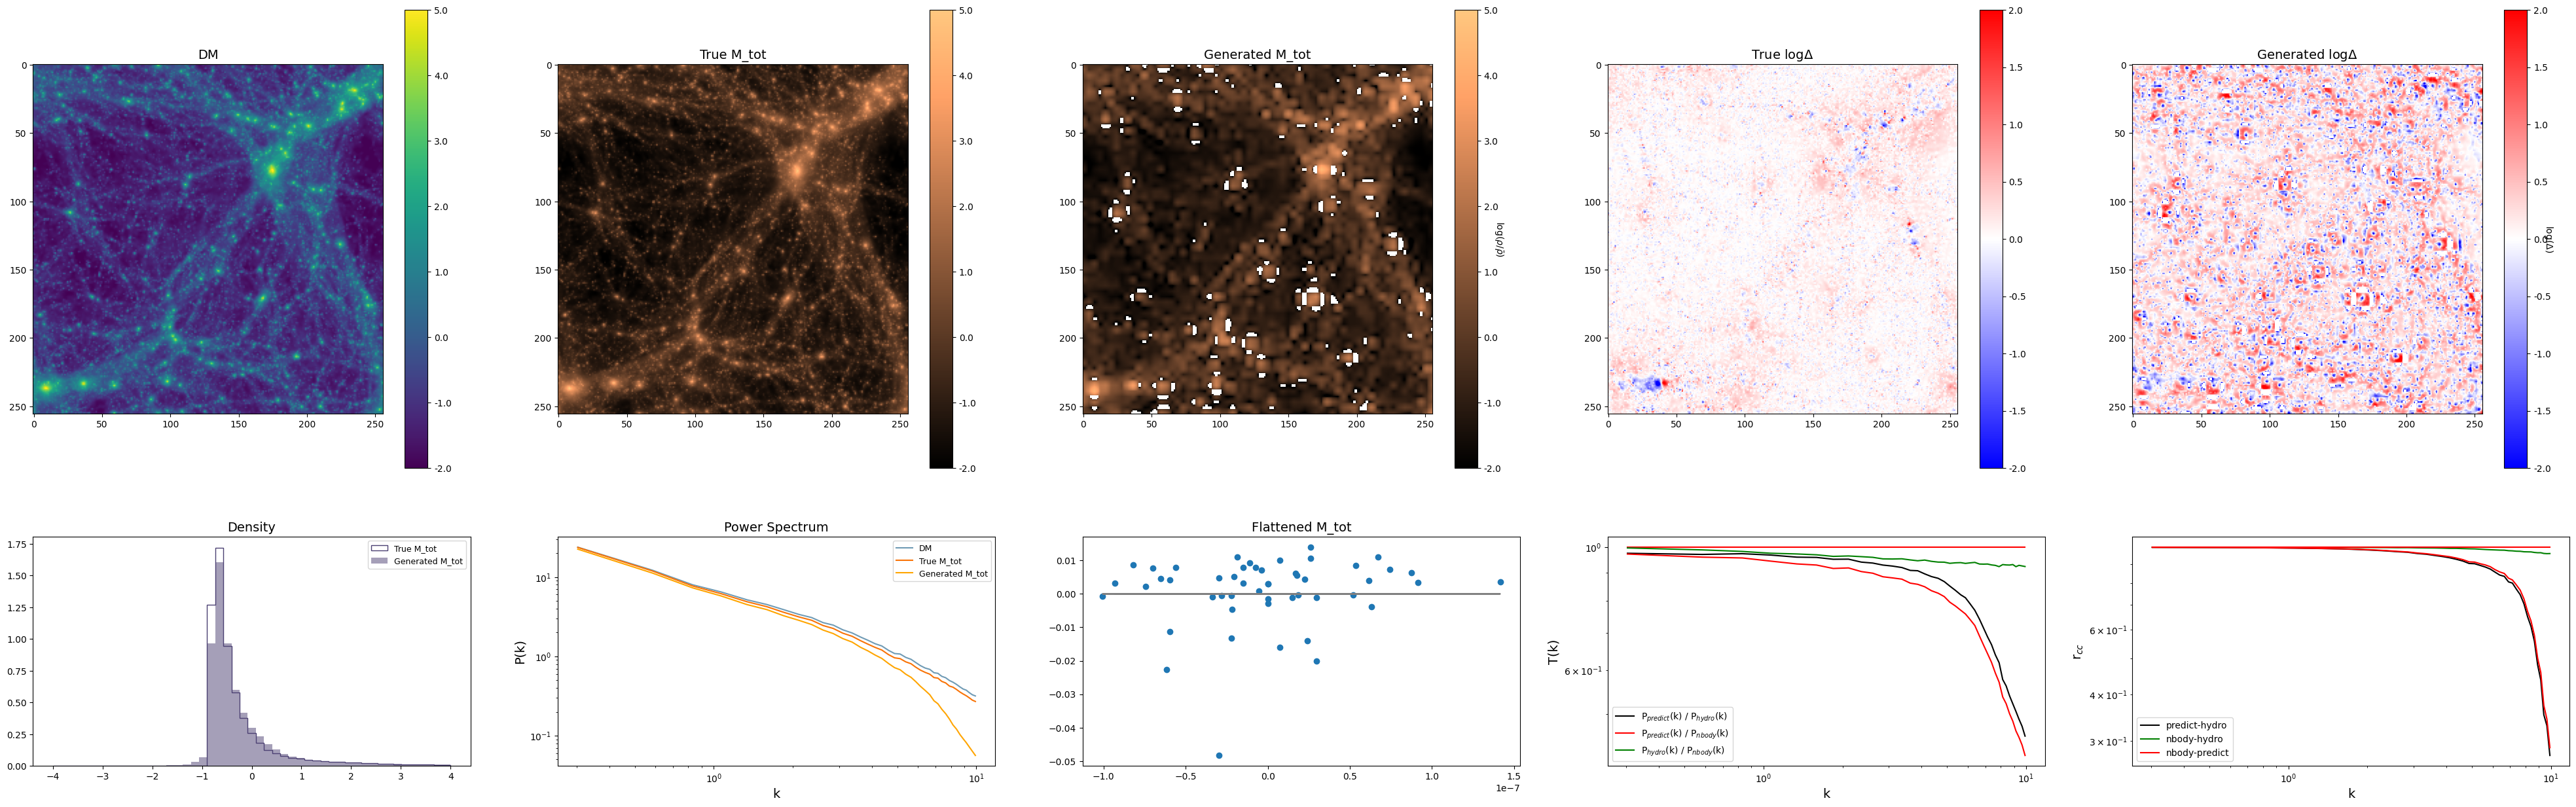

no high pass
Testing DataLoader 0: 100%|██████████| 6/6 [00:11<00:00,  0.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       fourier_loss        │    1.2947319746017456     │
│          l1_loss          │    0.5209683179855347     │
│         test_loss         │            0.0            │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet_TF_Film_epoch10_Fourier_ONLY_weight_1e5_3_10_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/f1270bef521a4ef9baed95e5a6fbefaa
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     fourier_loss  : 1.2947319746017456
COMET INFO:     l1_loss       : 0.5209683179855347
COMET INFO:     test_loss [2] : (0.0, 1.2278355360031128)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : ResNet_TF_Film_epoch10_Fourier_ONLY_weight_1e5_3_10_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:   Parameters:
COMET

In [25]:
test_loss = trainer.test(model=None, datamodule=dm_25_thick_mtot, ckpt_path = path)

In [16]:
comet_logger.experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/23e8b24c00fa47d783b8ee7e9e1d4edd

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet_TF_Film_epoch20_Moving_highk_log(Fourier)_ONLY_weight_1e5_10_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/23e8b24c00fa47d783b8ee7e9e1d4edd
COMET INFO:   Others

## Conditional CNN + Fourier Loss: m_cdm -> m_tot-m_cdm(Nbody) (3D->2D: 25 thickness)

In [3]:
dm_25_thick = get_astro_data(
        dataset,
        25,
        num_workers=num_workers,
        batch_size=batch_size,
    )

In [6]:
print(len(dm_25_thick.train_data), len(dm_25_thick.valid_data),len(dm_25_thick.test_data))

2100 600 300


In [ ]:
trainer.fit(model=cnn, datamodule=dm_25_thick) 

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/f16ffbf016854e018ab29f15be6af885

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | UNetFiLM | 44.2 M | train
-------------------------------------------
44.2 M    Trainable params
0         Non-trainable params
44.2 M    Total params
176.736   Total estimated model params size (MB)
105       Modules in train mode
0         Modules in eval mode
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (fourier_features): FourierFeatures()
  (inc): DoubleConv(
    (double_conv): Sequen

no high pass, no blue filter in training     | 0/2 [00:00<?, ?it/s]
no high pass, no blue filter in training
no high pass, no blue filter in training

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fi

Epoch 0, global step 175: 'val_rcc' reached 0.96027 (best 0.96027), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f16ffbf016854e018ab29f15be6af885/checkpoints/best_model-epoch=0-step=175.ckpt' as top 1


no high pass, no blue filter in training, ?it/s, v_num=f885, fourier_loss_step=7.44e-6, weighted_l1_loss_step=0.204, fourier_loss=1.13e-5, weighted_l1_loss=0.222, val_loss=1.13e-5, val_rcc=0.960, fourier_loss_epoch=1.17e-5, weighted_l1_loss_epoch=0.257]          
no high pass, no blue filter in training2:04,  1.39it/s, v_num=f885, fourier_loss_step=1.46e-5, weighted_l1_loss_step=0.234, fourier_loss=1.13e-5, weighted_l1_loss=0.222, val_loss=1.13e-5, val_rcc=0.960, fourier_loss_epoch=1.17e-5, weighted_l1_loss_epoch=0.257]
no high pass, no blue filter in training1:12,  2.38it/s, v_num=f885, fourier_loss_step=1.01e-5, weighted_l1_loss_step=0.221, fourier_loss=1.13e-5, weighted_l1_loss=0.222, val_loss=1.13e-5, val_rcc=0.960, fourier_loss_epoch=1.17e-5, weighted_l1_loss_epoch=0.257]
no high pass, no blue filter in training0:55,  3.12it/s, v_num=f885, fourier_loss_step=1.38e-5, weighted_l1_loss_step=0.245, fourier_loss=1.13e-5, weighted_l1_loss=0.222, val_loss=1.13e-5, val_rcc=0.960, fourier_

Epoch 1, global step 350: 'val_rcc' reached 0.96035 (best 0.96035), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f16ffbf016854e018ab29f15be6af885/checkpoints/best_model-epoch=1-step=350.ckpt' as top 1


no high pass, no blue filter in training, ?it/s, v_num=f885, fourier_loss_step=5.47e-6, weighted_l1_loss_step=0.195, fourier_loss=1.05e-5, weighted_l1_loss=0.211, val_loss=1.05e-5, val_rcc=0.960, fourier_loss_epoch=1.07e-5, weighted_l1_loss_epoch=0.223]          
no high pass, no blue filter in training1:56,  1.50it/s, v_num=f885, fourier_loss_step=1.44e-5, weighted_l1_loss_step=0.236, fourier_loss=1.05e-5, weighted_l1_loss=0.211, val_loss=1.05e-5, val_rcc=0.960, fourier_loss_epoch=1.07e-5, weighted_l1_loss_epoch=0.223]
no high pass, no blue filter in training1:08,  2.51it/s, v_num=f885, fourier_loss_step=7.46e-6, weighted_l1_loss_step=0.221, fourier_loss=1.05e-5, weighted_l1_loss=0.211, val_loss=1.05e-5, val_rcc=0.960, fourier_loss_epoch=1.07e-5, weighted_l1_loss_epoch=0.223]
no high pass, no blue filter in training0:52,  3.27it/s, v_num=f885, fourier_loss_step=1.32e-5, weighted_l1_loss_step=0.222, fourier_loss=1.05e-5, weighted_l1_loss=0.211, val_loss=1.05e-5, val_rcc=0.960, fourier_

Epoch 2, global step 525: 'val_rcc' was not in top 1


no high pass, no blue filter in training, ?it/s, v_num=f885, fourier_loss_step=9.78e-6, weighted_l1_loss_step=0.219, fourier_loss=9.84e-6, weighted_l1_loss=0.218, val_loss=9.84e-6, val_rcc=0.960, fourier_loss_epoch=9.87e-6, weighted_l1_loss_epoch=0.221]          
no high pass, no blue filter in training2:03,  1.41it/s, v_num=f885, fourier_loss_step=9.48e-6, weighted_l1_loss_step=0.218, fourier_loss=9.84e-6, weighted_l1_loss=0.218, val_loss=9.84e-6, val_rcc=0.960, fourier_loss_epoch=9.87e-6, weighted_l1_loss_epoch=0.221]
no high pass, no blue filter in training1:11,  2.41it/s, v_num=f885, fourier_loss_step=1.12e-5, weighted_l1_loss_step=0.228, fourier_loss=9.84e-6, weighted_l1_loss=0.218, val_loss=9.84e-6, val_rcc=0.960, fourier_loss_epoch=9.87e-6, weighted_l1_loss_epoch=0.221]
no high pass, no blue filter in training0:54,  3.14it/s, v_num=f885, fourier_loss_step=1.3e-5, weighted_l1_loss_step=0.226, fourier_loss=9.84e-6, weighted_l1_loss=0.218, val_loss=9.84e-6, val_rcc=0.960, fourier_l

Epoch 3, global step 700: 'val_rcc' was not in top 1


no high pass, no blue filter in training, ?it/s, v_num=f885, fourier_loss_step=1.13e-5, weighted_l1_loss_step=0.232, fourier_loss=1.01e-5, weighted_l1_loss=0.213, val_loss=1.01e-5, val_rcc=0.960, fourier_loss_epoch=9.62e-6, weighted_l1_loss_epoch=0.213]          
no high pass, no blue filter in training1:59,  1.45it/s, v_num=f885, fourier_loss_step=1.04e-5, weighted_l1_loss_step=0.221, fourier_loss=1.01e-5, weighted_l1_loss=0.213, val_loss=1.01e-5, val_rcc=0.960, fourier_loss_epoch=9.62e-6, weighted_l1_loss_epoch=0.213]
no high pass, no blue filter in training1:10,  2.47it/s, v_num=f885, fourier_loss_step=1.24e-5, weighted_l1_loss_step=0.216, fourier_loss=1.01e-5, weighted_l1_loss=0.213, val_loss=1.01e-5, val_rcc=0.960, fourier_loss_epoch=9.62e-6, weighted_l1_loss_epoch=0.213]
no high pass, no blue filter in training0:53,  3.21it/s, v_num=f885, fourier_loss_step=1.04e-5, weighted_l1_loss_step=0.221, fourier_loss=1.01e-5, weighted_l1_loss=0.213, val_loss=1.01e-5, val_rcc=0.960, fourier_

Epoch 4, global step 875: 'val_rcc' was not in top 1


no high pass, no blue filter in training, ?it/s, v_num=f885, fourier_loss_step=1.05e-5, weighted_l1_loss_step=0.230, fourier_loss=9.49e-6, weighted_l1_loss=0.207, val_loss=9.49e-6, val_rcc=0.960, fourier_loss_epoch=9.51e-6, weighted_l1_loss_epoch=0.210]          
no high pass, no blue filter in training2:02,  1.42it/s, v_num=f885, fourier_loss_step=9.86e-6, weighted_l1_loss_step=0.209, fourier_loss=9.49e-6, weighted_l1_loss=0.207, val_loss=9.49e-6, val_rcc=0.960, fourier_loss_epoch=9.51e-6, weighted_l1_loss_epoch=0.210]
no high pass, no blue filter in training1:11,  2.42it/s, v_num=f885, fourier_loss_step=9.28e-6, weighted_l1_loss_step=0.215, fourier_loss=9.49e-6, weighted_l1_loss=0.207, val_loss=9.49e-6, val_rcc=0.960, fourier_loss_epoch=9.51e-6, weighted_l1_loss_epoch=0.210]
no high pass, no blue filter in training0:54,  3.16it/s, v_num=f885, fourier_loss_step=8.01e-6, weighted_l1_loss_step=0.190, fourier_loss=9.49e-6, weighted_l1_loss=0.207, val_loss=9.49e-6, val_rcc=0.960, fourier_

Epoch 5, global step 1050: 'val_rcc' was not in top 1


no high pass, no blue filter in training, ?it/s, v_num=f885, fourier_loss_step=6.24e-6, weighted_l1_loss_step=0.186, fourier_loss=9.84e-6, weighted_l1_loss=0.204, val_loss=9.84e-6, val_rcc=0.960, fourier_loss_epoch=9.38e-6, weighted_l1_loss_epoch=0.206]          
no high pass, no blue filter in training1:59,  1.45it/s, v_num=f885, fourier_loss_step=9.39e-6, weighted_l1_loss_step=0.201, fourier_loss=9.84e-6, weighted_l1_loss=0.204, val_loss=9.84e-6, val_rcc=0.960, fourier_loss_epoch=9.38e-6, weighted_l1_loss_epoch=0.206]
no high pass, no blue filter in training1:10,  2.45it/s, v_num=f885, fourier_loss_step=7.69e-6, weighted_l1_loss_step=0.193, fourier_loss=9.84e-6, weighted_l1_loss=0.204, val_loss=9.84e-6, val_rcc=0.960, fourier_loss_epoch=9.38e-6, weighted_l1_loss_epoch=0.206]
no high pass, no blue filter in training0:53,  3.20it/s, v_num=f885, fourier_loss_step=6.02e-6, weighted_l1_loss_step=0.187, fourier_loss=9.84e-6, weighted_l1_loss=0.204, val_loss=9.84e-6, val_rcc=0.960, fourier_

Epoch 6, global step 1225: 'val_rcc' reached 0.96046 (best 0.96046), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f16ffbf016854e018ab29f15be6af885/checkpoints/best_model-epoch=6-step=1225.ckpt' as top 1


no high pass, no blue filter in training, ?it/s, v_num=f885, fourier_loss_step=5.93e-6, weighted_l1_loss_step=0.197, fourier_loss=9.58e-6, weighted_l1_loss=0.201, val_loss=9.58e-6, val_rcc=0.960, fourier_loss_epoch=9.34e-6, weighted_l1_loss_epoch=0.204]          
no high pass, no blue filter in training2:11,  1.33it/s, v_num=f885, fourier_loss_step=1.59e-5, weighted_l1_loss_step=0.226, fourier_loss=9.58e-6, weighted_l1_loss=0.201, val_loss=9.58e-6, val_rcc=0.960, fourier_loss_epoch=9.34e-6, weighted_l1_loss_epoch=0.204]
no high pass, no blue filter in training1:16,  2.27it/s, v_num=f885, fourier_loss_step=8.15e-6, weighted_l1_loss_step=0.196, fourier_loss=9.58e-6, weighted_l1_loss=0.201, val_loss=9.58e-6, val_rcc=0.960, fourier_loss_epoch=9.34e-6, weighted_l1_loss_epoch=0.204]
no high pass, no blue filter in training0:57,  3.00it/s, v_num=f885, fourier_loss_step=1.65e-5, weighted_l1_loss_step=0.205, fourier_loss=9.58e-6, weighted_l1_loss=0.201, val_loss=9.58e-6, val_rcc=0.960, fourier_

Epoch 7, global step 1400: 'val_rcc' was not in top 1


no high pass, no blue filter in training, ?it/s, v_num=f885, fourier_loss_step=9.29e-6, weighted_l1_loss_step=0.191, fourier_loss=1.18e-5, weighted_l1_loss=0.201, val_loss=1.18e-5, val_rcc=0.960, fourier_loss_epoch=1.11e-5, weighted_l1_loss_epoch=0.204]          
no high pass, no blue filter in training2:11,  1.32it/s, v_num=f885, fourier_loss_step=1.09e-5, weighted_l1_loss_step=0.191, fourier_loss=1.18e-5, weighted_l1_loss=0.201, val_loss=1.18e-5, val_rcc=0.960, fourier_loss_epoch=1.11e-5, weighted_l1_loss_epoch=0.204]
no high pass, no blue filter in training1:16,  2.26it/s, v_num=f885, fourier_loss_step=1.71e-5, weighted_l1_loss_step=0.226, fourier_loss=1.18e-5, weighted_l1_loss=0.201, val_loss=1.18e-5, val_rcc=0.960, fourier_loss_epoch=1.11e-5, weighted_l1_loss_epoch=0.204]
no high pass, no blue filter in training0:57,  2.99it/s, v_num=f885, fourier_loss_step=1.24e-5, weighted_l1_loss_step=0.216, fourier_loss=1.18e-5, weighted_l1_loss=0.201, val_loss=1.18e-5, val_rcc=0.960, fourier_

Epoch 8, global step 1575: 'val_rcc' was not in top 1


no high pass, no blue filter in training, ?it/s, v_num=f885, fourier_loss_step=1.14e-5, weighted_l1_loss_step=0.191, fourier_loss=1.21e-5, weighted_l1_loss=0.202, val_loss=1.21e-5, val_rcc=0.960, fourier_loss_epoch=1.11e-5, weighted_l1_loss_epoch=0.202]          
no high pass, no blue filter in training1:57,  1.48it/s, v_num=f885, fourier_loss_step=7.13e-6, weighted_l1_loss_step=0.183, fourier_loss=1.21e-5, weighted_l1_loss=0.202, val_loss=1.21e-5, val_rcc=0.960, fourier_loss_epoch=1.11e-5, weighted_l1_loss_epoch=0.202]
no high pass, no blue filter in training1:09,  2.48it/s, v_num=f885, fourier_loss_step=1.15e-5, weighted_l1_loss_step=0.217, fourier_loss=1.21e-5, weighted_l1_loss=0.202, val_loss=1.21e-5, val_rcc=0.960, fourier_loss_epoch=1.11e-5, weighted_l1_loss_epoch=0.202]
no high pass, no blue filter in training0:53,  3.22it/s, v_num=f885, fourier_loss_step=8.99e-6, weighted_l1_loss_step=0.183, fourier_loss=1.21e-5, weighted_l1_loss=0.202, val_loss=1.21e-5, val_rcc=0.960, fourier_

Epoch 9, global step 1750: 'val_rcc' was not in top 1


no high pass, no blue filter in training?, ?it/s, v_num=f885, fourier_loss_step=1.09e-5, weighted_l1_loss_step=0.203, fourier_loss=1.16e-5, weighted_l1_loss=0.203, val_loss=1.16e-5, val_rcc=0.960, fourier_loss_epoch=1.11e-5, weighted_l1_loss_epoch=0.202]         
no high pass, no blue filter in training02:06,  1.38it/s, v_num=f885, fourier_loss_step=9.05e-6, weighted_l1_loss_step=0.195, fourier_loss=1.16e-5, weighted_l1_loss=0.203, val_loss=1.16e-5, val_rcc=0.960, fourier_loss_epoch=1.11e-5, weighted_l1_loss_epoch=0.202]
no high pass, no blue filter in training01:13,  2.36it/s, v_num=f885, fourier_loss_step=1.13e-5, weighted_l1_loss_step=0.202, fourier_loss=1.16e-5, weighted_l1_loss=0.203, val_loss=1.16e-5, val_rcc=0.960, fourier_loss_epoch=1.11e-5, weighted_l1_loss_epoch=0.202]
no high pass, no blue filter in training00:55,  3.10it/s, v_num=f885, fourier_loss_step=1.21e-5, weighted_l1_loss_step=0.206, fourier_loss=1.16e-5, weighted_l1_loss=0.203, val_loss=1.16e-5, val_rcc=0.960, fouri

Epoch 10, global step 1925: 'val_rcc' was not in top 1


no high pass, no blue filter in training?, ?it/s, v_num=f885, fourier_loss_step=1.31e-5, weighted_l1_loss_step=0.219, fourier_loss=1.16e-5, weighted_l1_loss=0.202, val_loss=1.16e-5, val_rcc=0.960, fourier_loss_epoch=1.1e-5, weighted_l1_loss_epoch=0.202]          
no high pass, no blue filter in training02:00,  1.44it/s, v_num=f885, fourier_loss_step=9.43e-6, weighted_l1_loss_step=0.188, fourier_loss=1.16e-5, weighted_l1_loss=0.202, val_loss=1.16e-5, val_rcc=0.960, fourier_loss_epoch=1.1e-5, weighted_l1_loss_epoch=0.202]
no high pass, no blue filter in training01:10,  2.44it/s, v_num=f885, fourier_loss_step=9.6e-6, weighted_l1_loss_step=0.203, fourier_loss=1.16e-5, weighted_l1_loss=0.202, val_loss=1.16e-5, val_rcc=0.960, fourier_loss_epoch=1.1e-5, weighted_l1_loss_epoch=0.202] 
no high pass, no blue filter in training00:53,  3.20it/s, v_num=f885, fourier_loss_step=9.39e-6, weighted_l1_loss_step=0.198, fourier_loss=1.16e-5, weighted_l1_loss=0.202, val_loss=1.16e-5, val_rcc=0.960, fourier

Epoch 11, global step 2100: 'val_rcc' was not in top 1


no high pass, no blue filter in training?, ?it/s, v_num=f885, fourier_loss_step=7.75e-6, weighted_l1_loss_step=0.185, fourier_loss=1.15e-5, weighted_l1_loss=0.208, val_loss=1.15e-5, val_rcc=0.960, fourier_loss_epoch=1.12e-5, weighted_l1_loss_epoch=0.205]          
no high pass, no blue filter in training02:02,  1.42it/s, v_num=f885, fourier_loss_step=5.64e-6, weighted_l1_loss_step=0.176, fourier_loss=1.15e-5, weighted_l1_loss=0.208, val_loss=1.15e-5, val_rcc=0.960, fourier_loss_epoch=1.12e-5, weighted_l1_loss_epoch=0.205]
no high pass, no blue filter in training01:11,  2.41it/s, v_num=f885, fourier_loss_step=1.18e-5, weighted_l1_loss_step=0.210, fourier_loss=1.15e-5, weighted_l1_loss=0.208, val_loss=1.15e-5, val_rcc=0.960, fourier_loss_epoch=1.12e-5, weighted_l1_loss_epoch=0.205]
no high pass, no blue filter in training00:54,  3.15it/s, v_num=f885, fourier_loss_step=1.69e-5, weighted_l1_loss_step=0.210, fourier_loss=1.15e-5, weighted_l1_loss=0.208, val_loss=1.15e-5, val_rcc=0.960, four

Epoch 12, global step 2275: 'val_rcc' reached 0.96102 (best 0.96102), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f16ffbf016854e018ab29f15be6af885/checkpoints/best_model-epoch=12-step=2275.ckpt' as top 1


no high pass, no blue filter in training?, ?it/s, v_num=f885, fourier_loss_step=6.62e-6, weighted_l1_loss_step=0.186, fourier_loss=1.13e-5, weighted_l1_loss=0.204, val_loss=1.13e-5, val_rcc=0.961, fourier_loss_epoch=1.11e-5, weighted_l1_loss_epoch=0.203]          
no high pass, no blue filter in training02:01,  1.43it/s, v_num=f885, fourier_loss_step=6.36e-6, weighted_l1_loss_step=0.186, fourier_loss=1.13e-5, weighted_l1_loss=0.204, val_loss=1.13e-5, val_rcc=0.961, fourier_loss_epoch=1.11e-5, weighted_l1_loss_epoch=0.203]
no high pass, no blue filter in training01:11,  2.41it/s, v_num=f885, fourier_loss_step=7.6e-6, weighted_l1_loss_step=0.184, fourier_loss=1.13e-5, weighted_l1_loss=0.204, val_loss=1.13e-5, val_rcc=0.961, fourier_loss_epoch=1.11e-5, weighted_l1_loss_epoch=0.203] 
no high pass, no blue filter in training00:54,  3.16it/s, v_num=f885, fourier_loss_step=7.53e-6, weighted_l1_loss_step=0.192, fourier_loss=1.13e-5, weighted_l1_loss=0.204, val_loss=1.13e-5, val_rcc=0.961, four

In [28]:
best_path = val_checkpoint.best_model_path 
print(best_path)

/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/48c6169ffa0b4da2a553c28288d8b64a/checkpoints/best_model-epoch=7-step=1400.ckpt


In [29]:
last_path = trainer.checkpoint_callback.best_model_path 
print(last_path)

/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/48c6169ffa0b4da2a553c28288d8b64a/checkpoints/latest-epoch=19-step=3500.ckpt


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/48c6169ffa0b4da2a553c28288d8b64a

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/48c6169ffa0b4da2a553c28288d8b64a/checkpoints/latest-epoch=19-step=3500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (fourier_features): FourierFeatures()
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

no high pass, no blue filter in training/6 [00:00<?, ?it/s]

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spect

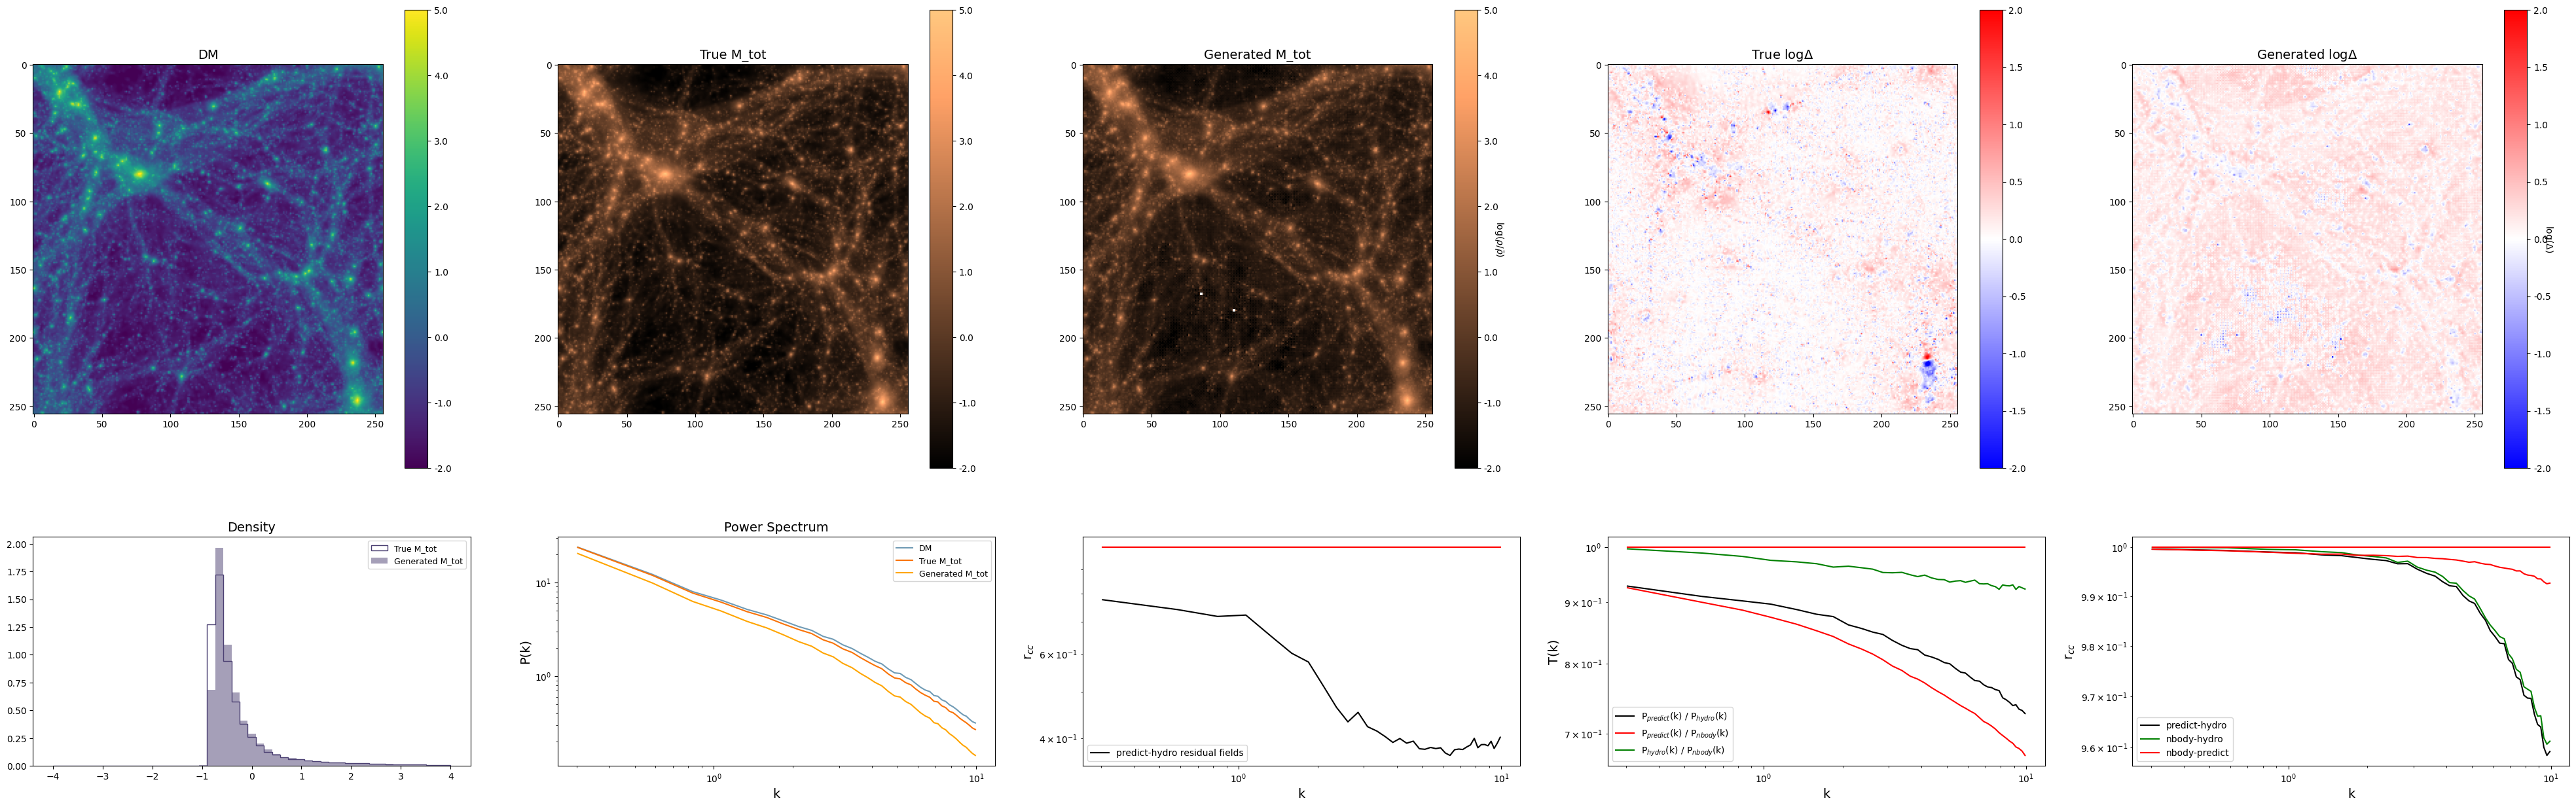

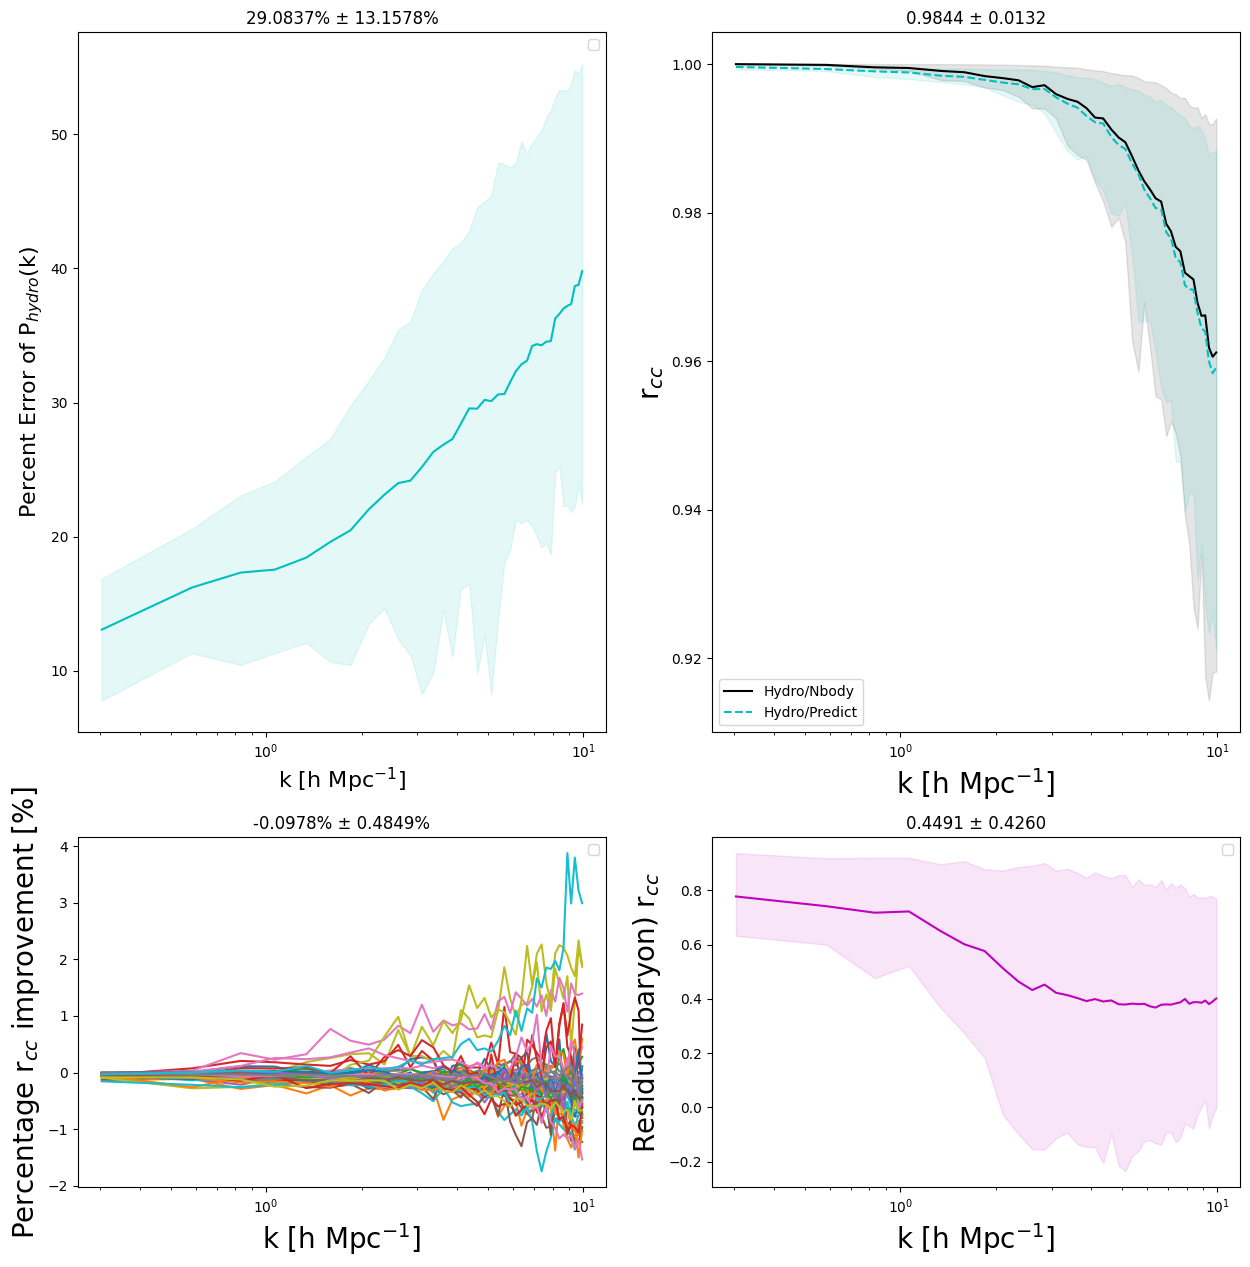

no high pass, no blue filter in training
no high pass, no blue filter in training/6 [00:12<01:01,  0.08it/s]
no high pass, no blue filter in training/6 [00:12<00:24,  0.16it/s]
no high pass, no blue filter in training/6 [00:12<00:12,  0.24it/s]
no high pass, no blue filter in training/6 [00:12<00:06,  0.32it/s]
no high pass, no blue filter in training/6 [00:12<00:02,  0.39it/s]
Testing DataLoader 0: 100%|██████████| 6/6 [00:12<00:00,  0.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       fourier_loss        │   2.00972608581651e-05    │
│         test_loss         │            0.0            │
│     weighted_l1_loss      │    0.22250205278396606    │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : UNet_Film_vali_rcc_lr_tuning_warmup_fourier_feature_6_7_epoch20_moving_highk_log_Fourier_ONLY_weight_1e5_10_Smooth_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/48c6169ffa0b4da2a553c28288d8b64a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     fourier_loss     : 2.00972608581651e-05
COMET INFO:     test_loss [2]    : (0.0, 1.9227914890507236e-05)
COMET INFO:     weighted_l1_loss : 0.22250205278396606
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : UNet_Film_vali_rcc_lr_tuning_warmup_fourier_feature_

In [31]:
#model = None: directly load from ckpt
test_loss = trainer.test(model=cnn, datamodule=dm_25_thick, ckpt_path = last_path)

In [28]:
comet_logger.experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/820b7b8d0721410185b3bedfe93cdb81

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : UNet_Film_epoch2_fourier_feature_6_7_epoch10_moving_highk_log(Fourier)_ONLY_weight_1e5_10_Smooth_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/820b7b8d0721410185b3bedf

## Conditional CNN + Fourier Loss + TF: m_cdm -> m_tot-m_cdm_tf (3D->2D: 25 thickness)

In [8]:
dm_TF = get_astro_data_2D_from_3D(
        dataset,
        num_workers=num_workers,
        resize=cropsize,
        batch_size=batch_size)

In [11]:
print(len(dm_TF.train_data), len(dm_TF.valid_data),len(dm_TF.test_data)) #sum to 3000

2400 420 180


In [ ]:
path = trainer.checkpoint_callback.best_model_path 
print(path)

In [8]:
path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere_25_thick = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/5ef90d60aaca4012837cd4275273e171/checkpoints/latest-epoch=9-step=1750.ckpt'
path_UNet_Film_10_epochs_ONLY_l1_loss_25_thick = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/62ce892d8ce84414ad1d864f0b3c09a3/checkpoints/latest-epoch=9-step=1750.ckpt'

## test if CNN_apply is correct --> ✅

In [ ]:
comet_logger.experiment.end()

In [70]:
test_predictions_ONLY_fourier_loss = trainer.predict(model=cnn, dataloaders=dm_25_thick.train_dataloader(), ckpt_path = path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere_25_thick)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/96071eeeabd64a0da32d6e71b78e41a9

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/5ef90d60aaca4012837cd4275273e171/checkpoints/latest-epoch=9-step=1750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

Predicting DataLoader 0: 100%|██████████| 175/175 [00:05<00:00, 29.50it/s]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_new_Film_Fourier_L1_weight_1e-4_2_20_high_pass_lr_5e-3_25_thickness
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/96071eeeabd64a0da32d6e71b78e41a9
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_new_Film_Fourier_L1_weight_1e-4_2_20_high_pass_lr_5e-3_25_thickness
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.005
COMET INFO:     model            : UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel

In [72]:
test_predictions_ONLY_fourier_loss = np.array(test_predictions_ONLY_fourier_loss).reshape([2100,256,256]) #path_UNet_Film_50_epochs_fourier_loss_2_10

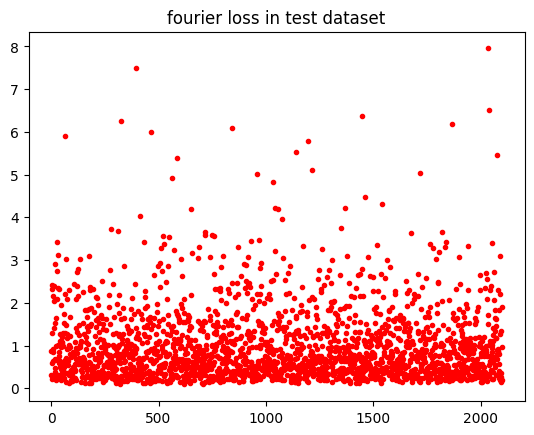

In [86]:
test_target = []
for t in dm_25_thick.train_data:
    test_target.append(t[2])
    
test_predictions_ONLY_fourier_loss_ = Tensor(np.array(test_predictions_ONLY_fourier_loss)).unsqueeze(1)
test_predictions_ = Tensor(test_predictions).unsqueeze(1)

plt.figure()
for i in np.arange(len(test_predictions)):                
    loss = cnn.fourier_loss(test_predictions_ONLY_fourier_loss_[i].unsqueeze(0), test_target[i])
    plt.plot(i, loss, '.', c='r')
plt.title('fourier loss in test dataset')
plt.show()

In [84]:
print(len(test_target))

2100


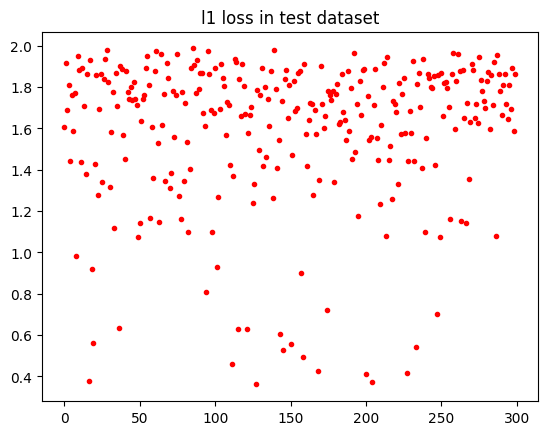

In [44]:
plt.figure()
for i in np.arange(len(test_predictions)):                
    loss =  l1_loss(test_predictions_[i].unsqueeze(0), test_targets_[i])
    plt.plot(i, loss, '.', c='r')
plt.title('l1 loss in test dataset')
plt.show()

In [75]:
test_predictions = trainer.predict(model=cnn, dataloaders=dm_25_thick.train_dataloader(), ckpt_path = path_UNet_Film_10_epochs_ONLY_l1_loss_25_thick)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/96071eeeabd64a0da32d6e71b78e41a9

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/62ce892d8ce84414ad1d864f0b3c09a3/checkpoints/latest-epoch=9-step=1750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

Predicting DataLoader 0: 100%|██████████| 175/175 [00:05<00:00, 29.36it/s]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_new_Film_Fourier_L1_weight_1e-4_2_20_high_pass_lr_5e-3_25_thickness
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/96071eeeabd64a0da32d6e71b78e41a9
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_new_Film_Fourier_L1_weight_1e-4_2_20_high_pass_lr_5e-3_25_thickness
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.005
COMET INFO:     model            : UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel

train on L1 only


/tmp/ipykernel_1997182/3169583532.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_predictions = Tensor(np.array(test_predictions).reshape([2100,1,256,256]))


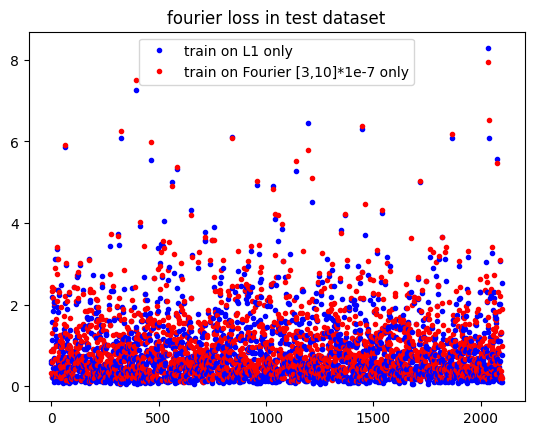

/tmp/ipykernel_1997182/3169583532.py:23: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss =  l1_loss(test_predictions[i].unsqueeze(0), test_target[i])
/tmp/ipykernel_1997182/3169583532.py:28: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = l1_loss(test_predictions_ONLY_fourier_loss_[i].unsqueeze(0), test_target[i])


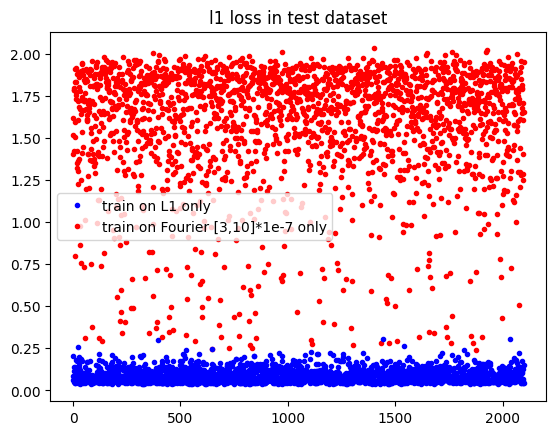

In [87]:
print('train on L1 only')

test_predictions = Tensor(np.array(test_predictions).reshape([2100,1,256,256]))

plt.figure()
for i in np.arange(len(test_predictions)):                
    loss = cnn.fourier_loss(test_predictions[i].unsqueeze(0), test_target[i])
    if i == 0:
        plt.plot(i, loss, '.', c='b', label = 'train on L1 only')
    else:
        plt.plot(i, loss, '.', c='b')
    loss = cnn.fourier_loss(test_predictions_ONLY_fourier_loss_[i].unsqueeze(0), test_target[i])
    if i == 0:
        plt.plot(i, loss, '.', c='r', label = 'train on Fourier [3,10]*1e-7 only')
    else:
        plt.plot(i, loss, '.', c='r')
plt.title('fourier loss in test dataset')
plt.legend()
plt.show()

plt.figure()
for i in np.arange(len(test_predictions)):                
    loss =  l1_loss(test_predictions[i].unsqueeze(0), test_target[i])
    if i == 0:
        plt.plot(i, loss, '.', c='b', label = 'train on L1 only')
    else:
        plt.plot(i, loss, '.', c='b')
    loss = l1_loss(test_predictions_ONLY_fourier_loss_[i].unsqueeze(0), test_target[i])
    if i == 0:
        plt.plot(i, loss, '.', c='r', label = 'train on Fourier [3,10]*1e-7 only')
    else:
        plt.plot(i, loss, '.', c='r')
plt.title('l1 loss in test dataset')
plt.legend()
plt.show()